In [20]:
import networkx as nx
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.callbacks import get_openai_callback
from langchain_ollama import OllamaEmbeddings, OllamaLLM
from langchain_community.document_loaders import PyPDFLoader

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import List, Tuple, Dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import spacy
import heapq


from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np

from spacy.cli import download
from spacy.lang.en import English

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [13]:
# Define the DocumentProcessor class
class DocumentProcessor:
    def __init__(self):
        """
        Initializes the DocumentProcessor with a text splitter and OpenAI embeddings.
        
        Attributes:
        - text_splitter: An instance of RecursiveCharacterTextSplitter with specified chunk size and overlap.
        - embeddings: An instance of OpenAIEmbeddings used for embedding documents.
        """
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        self.embeddings = OllamaEmbeddings(model="nomic-embed-text")

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into smaller chunks and creating a vector store.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - tuple: A tuple containing:
          - splits (list of str): The list of split document chunks.
          - vector_store (FAISS): A FAISS vector store created from the split document chunks and their embeddings.
        """
        splits = self.text_splitter.split_documents(documents)
        vector_store = FAISS.from_documents(splits, self.embeddings)
        return splits, vector_store

    def create_embeddings_batch(self, texts, batch_size=32):
        """
        Creates embeddings for a list of texts in batches.
        
        Args:
        - texts (list of str): A list of texts to be embedded.
        - batch_size (int, optional): The number of texts to process in each batch. Default is 32.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the input texts.
        """
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = self.embeddings.embed_documents(batch)
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

    def compute_similarity_matrix(self, embeddings):
        """
        Computes a cosine similarity matrix for a given set of embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the input embeddings.
        """
        return cosine_similarity(embeddings)

In [37]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import spacy
from spacy.cli import download
from nltk.stem import WordNetLemmatizer
import json

class KnowledgeGraph:
    def __init__(self):
        self.graph = nx.Graph()
        self.lemmatizer = WordNetLemmatizer()
        self.concept_cache = {}
        self.nlp = self._load_spacy_model()
        self.edges_threshold = 0.8

    def build_graph(self, splits, llm, embedding_model):
        self._add_nodes(splits)
        embeddings = self._create_embeddings(splits, embedding_model)
        self._extract_concepts(splits, llm)
        # Ensure every node has 'concepts' key
        for node in self.graph.nodes:
            if 'concepts' not in self.graph.nodes[node]:
                self.graph.nodes[node]['concepts'] = []
        self._add_edges(embeddings)

    def _add_nodes(self, splits):
        for i, split in enumerate(splits):
            self.graph.add_node(i, content=split.page_content)

    def _create_embeddings(self, splits, embedding_model):
        texts = [split.page_content for split in splits]
        return embedding_model.embed_documents(texts)

    def _compute_similarities(self, embeddings):
        return cosine_similarity(embeddings)

    def _load_spacy_model(self):
        try:
            return spacy.load("en_core_web_sm")
        except OSError:
            print("Downloading spaCy model...")
            download("en_core_web_sm")
            return spacy.load("en_core_web_sm")

    def _extract_concepts_and_entities(self, content, llm):
        if content in self.concept_cache:
            return self.concept_cache[content]

        # Named entities
        doc = self.nlp(content)
        named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "WORK_OF_ART"]]

        # LLM concepts extraction
        prompt = f"""
        Extract key concepts (excluding named entities) from the text below.
        Return JSON only in this format: {{"concepts_list": ["concept1", "concept2"]}}

        Text:
        {content}
        """
        try:
            response = llm.invoke({"prompt": prompt})
            general_concepts = json.loads(response).get("concepts_list", [])
        except (json.JSONDecodeError, KeyError, TypeError):
            general_concepts = []

        all_concepts = list(set(named_entities + general_concepts))
        self.concept_cache[content] = all_concepts
        return all_concepts

    def _extract_concepts(self, splits, llm):
        with ThreadPoolExecutor() as executor:
            future_to_node = {executor.submit(self._extract_concepts_and_entities, split.page_content, llm): i
                              for i, split in enumerate(splits)}
            for future in tqdm(as_completed(future_to_node), total=len(splits), desc="Extracting concepts"):
                node = future_to_node[future]
                try:
                    concepts = future.result()
                except Exception:
                    concepts = []
                self.graph.nodes[node]['concepts'] = concepts

    def _add_edges(self, embeddings):
        similarity_matrix = self._compute_similarities(embeddings)
        num_nodes = len(self.graph.nodes)

        for node1 in tqdm(range(num_nodes), desc="Adding edges"):
            for node2 in range(node1 + 1, num_nodes):
                sim_score = similarity_matrix[node1][node2]
                if sim_score > self.edges_threshold:
                    shared = set(self.graph.nodes[node1]['concepts']) & set(self.graph.nodes[node2]['concepts'])
                    weight = self._calculate_edge_weight(node1, node2, sim_score, shared)
                    self.graph.add_edge(node1, node2, weight=weight,
                                        similarity=sim_score,
                                        shared_concepts=list(shared))

    def _calculate_edge_weight(self, node1, node2, sim_score, shared, alpha=0.7, beta=0.3):
        max_shared = min(len(self.graph.nodes[node1]['concepts']),
                         len(self.graph.nodes[node2]['concepts']))
        norm_shared = len(shared) / max_shared if max_shared > 0 else 0
        return alpha * sim_score + beta * norm_shared

    def _lemmatize_concept(self, concept):
        return ' '.join([self.lemmatizer.lemmatize(w) for w in concept.lower().split()])


In [38]:
# ==============================
# Ollama-compatible Query Engine
# ==============================

import heapq
from typing import List, Tuple, Dict
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate

# ------------------------------
# AnswerCheck class
# ------------------------------
class AnswerCheck(BaseModel):
    is_complete: bool = Field(description="Whether the current context provides a complete answer to the query")
    answer: str = Field(description="The current answer based on the context, if any")

# ------------------------------
# QueryEngine class
# ------------------------------
class QueryEngine:
    def __init__(self, vector_store, knowledge_graph, llm):
        self.vector_store = vector_store
        self.knowledge_graph = knowledge_graph
        self.llm = llm
        self.max_context_length = 4000

    # ------------------------------
    # Answer check (Ollama-safe)
    # ------------------------------
    def _check_answer(self, query: str, context: str) -> Tuple[bool, str]:
        prompt = PromptTemplate(
            input_variables=["query", "context"],
            template=(
                "Given the query: '{query}'\n"
                "And the current context:\n{context}\n\n"
                "Does this context provide a complete answer? Return ONLY valid JSON:\n"
                "{{\"is_complete\": true/false, \"answer\": \"answer if complete\"}}"
            ),
        )

        raw_response = self.llm.invoke(prompt.format(query=query, context=context))
        try:
            parsed = json.loads(raw_response)
            validated = AnswerCheck(**parsed)
            return validated.is_complete, validated.answer
        except Exception:
            return False, ""

    # ------------------------------
    # Context expansion using graph traversal
    # ------------------------------
    def _expand_context(self, query: str, relevant_docs) -> Tuple[str, List[int], Dict[int, str], str]:
        expanded_context = ""
        traversal_path = []
        visited_concepts = set()
        filtered_content = {}
        final_answer = ""

        priority_queue = []
        distances = {}

        # Initialize priority queue with closest nodes
        for doc in relevant_docs:
            closest_nodes = self.vector_store.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, similarity_score = closest_nodes[0]
            closest_node = next(n for n in self.knowledge_graph.graph.nodes if self.knowledge_graph.graph.nodes[n]['content'] == closest_node_content.page_content)
            priority = 1 / similarity_score
            heapq.heappush(priority_queue, (priority, closest_node))
            distances[closest_node] = priority

        while priority_queue:
            current_priority, current_node = heapq.heappop(priority_queue)
            if current_priority > distances.get(current_node, float('inf')):
                continue

            if current_node not in traversal_path:
                traversal_path.append(current_node)
                node_content = self.knowledge_graph.graph.nodes[current_node]['content']
                node_concepts = self.knowledge_graph.graph.nodes[current_node]['concepts']
                filtered_content[current_node] = node_content
                expanded_context += "\n" + node_content if expanded_context else node_content

                is_complete, answer = self._check_answer(query, expanded_context)
                if is_complete:
                    final_answer = answer
                    break

                node_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in node_concepts)
                if not node_concepts_set.issubset(visited_concepts):
                    visited_concepts.update(node_concepts_set)
                    for neighbor in self.knowledge_graph.graph.neighbors(current_node):
                        edge_weight = self.knowledge_graph.graph[current_node][neighbor]['weight']
                        distance = current_priority + (1 / edge_weight)
                        if distance < distances.get(neighbor, float('inf')):
                            distances[neighbor] = distance
                            heapq.heappush(priority_queue, (distance, neighbor))

            if final_answer:
                break

        if not final_answer:
            prompt = PromptTemplate(
                input_variables=["query", "context"],
                template="Based on the following context, please answer the query.\n\nContext: {context}\nQuery: {query}\nAnswer:"
            )
            final_answer = self.llm.invoke(prompt.format(query=query, context=expanded_context))

        return expanded_context, traversal_path, filtered_content, final_answer

    # ------------------------------
    # Main query interface
    # ------------------------------
    def query(self, query: str) -> Tuple[str, List[int], Dict[int, str]]:
        print(f"\nProcessing query: {query}")
        relevant_docs = self._retrieve_relevant_documents(query)
        expanded_context, traversal_path, filtered_content, final_answer = self._expand_context(query, relevant_docs)
        print(f"\nFinal Answer: {final_answer}")
        return final_answer, traversal_path, filtered_content

    # ------------------------------
    # Document retrieval
    # ------------------------------
    def _retrieve_relevant_documents(self, query: str):
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        return retriever.get_relevant_documents(query)

In [39]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the Visualizer class
class Visualizer:
    @staticmethod
    def visualize_traversal(graph, traversal_path):
        """
        Visualizes the traversal path on the knowledge graph with nodes, edges, and traversal path highlighted.

        Args:
        - graph (networkx.Graph): The knowledge graph containing nodes and edges.
        - traversal_path (list of int): The list of node indices representing the traversal path.

        Returns:
        - None
        """
        traversal_graph = nx.DiGraph()
        
        # Add nodes and edges from the original graph
        for node in graph.nodes():
            traversal_graph.add_node(node)
        for u, v, data in graph.edges(data=True):
            traversal_graph.add_edge(u, v, **data)
        
        fig, ax = plt.subplots(figsize=(16, 12))
        
        # Generate positions for all nodes
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)
        
        # Draw regular edges with color based on weight
        edges = traversal_graph.edges()
        edge_weights = [traversal_graph[u][v].get('weight', 0.5) for u, v in edges]
        nx.draw_networkx_edges(traversal_graph, pos, 
                               edgelist=edges,
                               edge_color=edge_weights,
                               edge_cmap=plt.cm.Blues,
                               width=2,
                               ax=ax)
        
        # Draw nodes
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               node_color='lightblue',
                               node_size=3000,
                               ax=ax)
        
        # Draw traversal path with curved arrows
        edge_offset = 0.1
        for i in range(len(traversal_path) - 1):
            start = traversal_path[i]
            end = traversal_path[i + 1]
            start_pos = pos[start]
            end_pos = pos[end]
            
            # Calculate control point for curve
            mid_point = ((start_pos[0] + end_pos[0]) / 2, (start_pos[1] + end_pos[1]) / 2)
            control_point = (mid_point[0] + edge_offset, mid_point[1] + edge_offset)
            
            # Draw curved arrow
            arrow = patches.FancyArrowPatch(start_pos, end_pos,
                                            connectionstyle=f"arc3,rad={0.3}",
                                            color='red',
                                            arrowstyle="->",
                                            mutation_scale=20,
                                            linestyle='--',
                                            linewidth=2,
                                            zorder=4)
            ax.add_patch(arrow)
        
        # Prepare labels for the nodes
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = graph.nodes[node].get('concepts', [])
            label = f"{i + 1}. {concepts[0] if concepts else ''}"
            labels[node] = label
        
        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''
        
        # Draw labels
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold", ax=ax)
        
        # Highlight start and end nodes
        start_node = traversal_path[0]
        end_node = traversal_path[-1]
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[start_node], 
                               node_color='lightgreen', 
                               node_size=3000,
                               ax=ax)
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[end_node], 
                               node_color='lightcoral', 
                               node_size=3000,
                               ax=ax)
        
        ax.set_title("Graph Traversal Flow")
        ax.axis('off')
        
        # Add colorbar for edge weights
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Edge Weight', rotation=270, labelpad=15)
        
        # Add legend
        regular_line = plt.Line2D([0], [0], color='blue', linewidth=2, label='Regular Edge')
        traversal_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Traversal Path')
        start_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Start Node')
        end_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=15, label='End Node')
        legend = plt.legend(handles=[regular_line, traversal_line, start_point, end_point], loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
        legend.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_filtered_content(traversal_path, filtered_content):
        """
        Prints the filtered content of visited nodes in the order of traversal.

        Args:
        - traversal_path (list of int): The list of node indices representing the traversal path.
        - filtered_content (dict of int: str): A dictionary mapping node indices to their filtered content.

        Returns:
        - None
        """
        print("\nFiltered content of visited nodes in order of traversal:")
        for i, node in enumerate(traversal_path):
            print(f"\nStep {i + 1} - Node {node}:")
            print(f"Filtered Content: {filtered_content.get(node, 'No filtered content available')[:200]}...")  # Print first 200 characters
            print("-" * 50)

In [40]:
class GraphRAG:
    def __init__(self):
        """
        Initializes the GraphRAG system with components for document processing, knowledge graph construction,
        querying, and visualization.
        """
        # LLM and embedding models
        self.llm = OllamaLLM(model="llama3")
        self.embedding_model = OllamaEmbeddings(model="nomic-embed-text")
        
        # Document processor and knowledge graph
        self.document_processor = DocumentProcessor()
        self.knowledge_graph = KnowledgeGraph()
        
        # Query engine will be initialized after documents are processed
        self.query_engine = None
        
        # Visualizer for graph traversal
        self.visualizer = Visualizer()

    def process_documents(self, documents: list):
        """
        Processes a list of documents by splitting them, embedding them, and building the knowledge graph.

        Args:
        - documents (list of str): List of document texts.
        """
        # Split documents and create vector store
        splits, vector_store = self.document_processor.process_documents(documents)
        
        # Build knowledge graph using splits
        self.knowledge_graph.build_graph(splits, self.llm, self.embedding_model)
        
        # Initialize query engine
        self.query_engine = QueryEngine(vector_store, self.knowledge_graph, self.llm)

    def query(self, query: str):
        """
        Handles a query by retrieving relevant information from the knowledge graph and visualizing the traversal.

        Args:
        - query (str): The user query.

        Returns:
        - str: The final answer to the query.
        """
        if not self.query_engine:
            raise ValueError("Query engine not initialized. Please process documents first.")

        # Retrieve answer and traversal information
        response, traversal_path, filtered_content = self.query_engine.query(query)

        # Visualize the traversal path
        if traversal_path:
            self.visualizer.visualize_traversal(self.knowledge_graph.graph, traversal_path)
            self.visualizer.print_filtered_content(traversal_path, filtered_content)
        else:
            print("No traversal path found for the query.")

        return response


In [41]:
path = "data/Understanding_Climate_Change.pdf"

loader = PyPDFLoader(path)
documents = loader.load()
documents = documents[:10]

In [42]:
graph_rag = GraphRAG()

In [43]:
graph_rag.process_documents(documents)

Adding edges: 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85250.08it/s]



Processing query: what is the main cause of climate change?


/var/folders/bx/b60shh3d5fgcy2bhfzqsdnn00000gn/T/ipykernel_7850/4113006899.py:125: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return retriever.get_relevant_documents(query)
/var/folders/bx/b60shh3d5fgcy2bhfzqsdnn00000gn/T/ipykernel_7850/4113006899.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  priority = 1 / similarity_score



Final Answer: According to the context, the main cause of recent climate change is the increase in greenhouse gases in the atmosphere, particularly carbon dioxide (CO2), methane (CH4), and nitrous oxide (N2O). This increase is primarily driven by human activities, such as burning fossil fuels and deforestation.


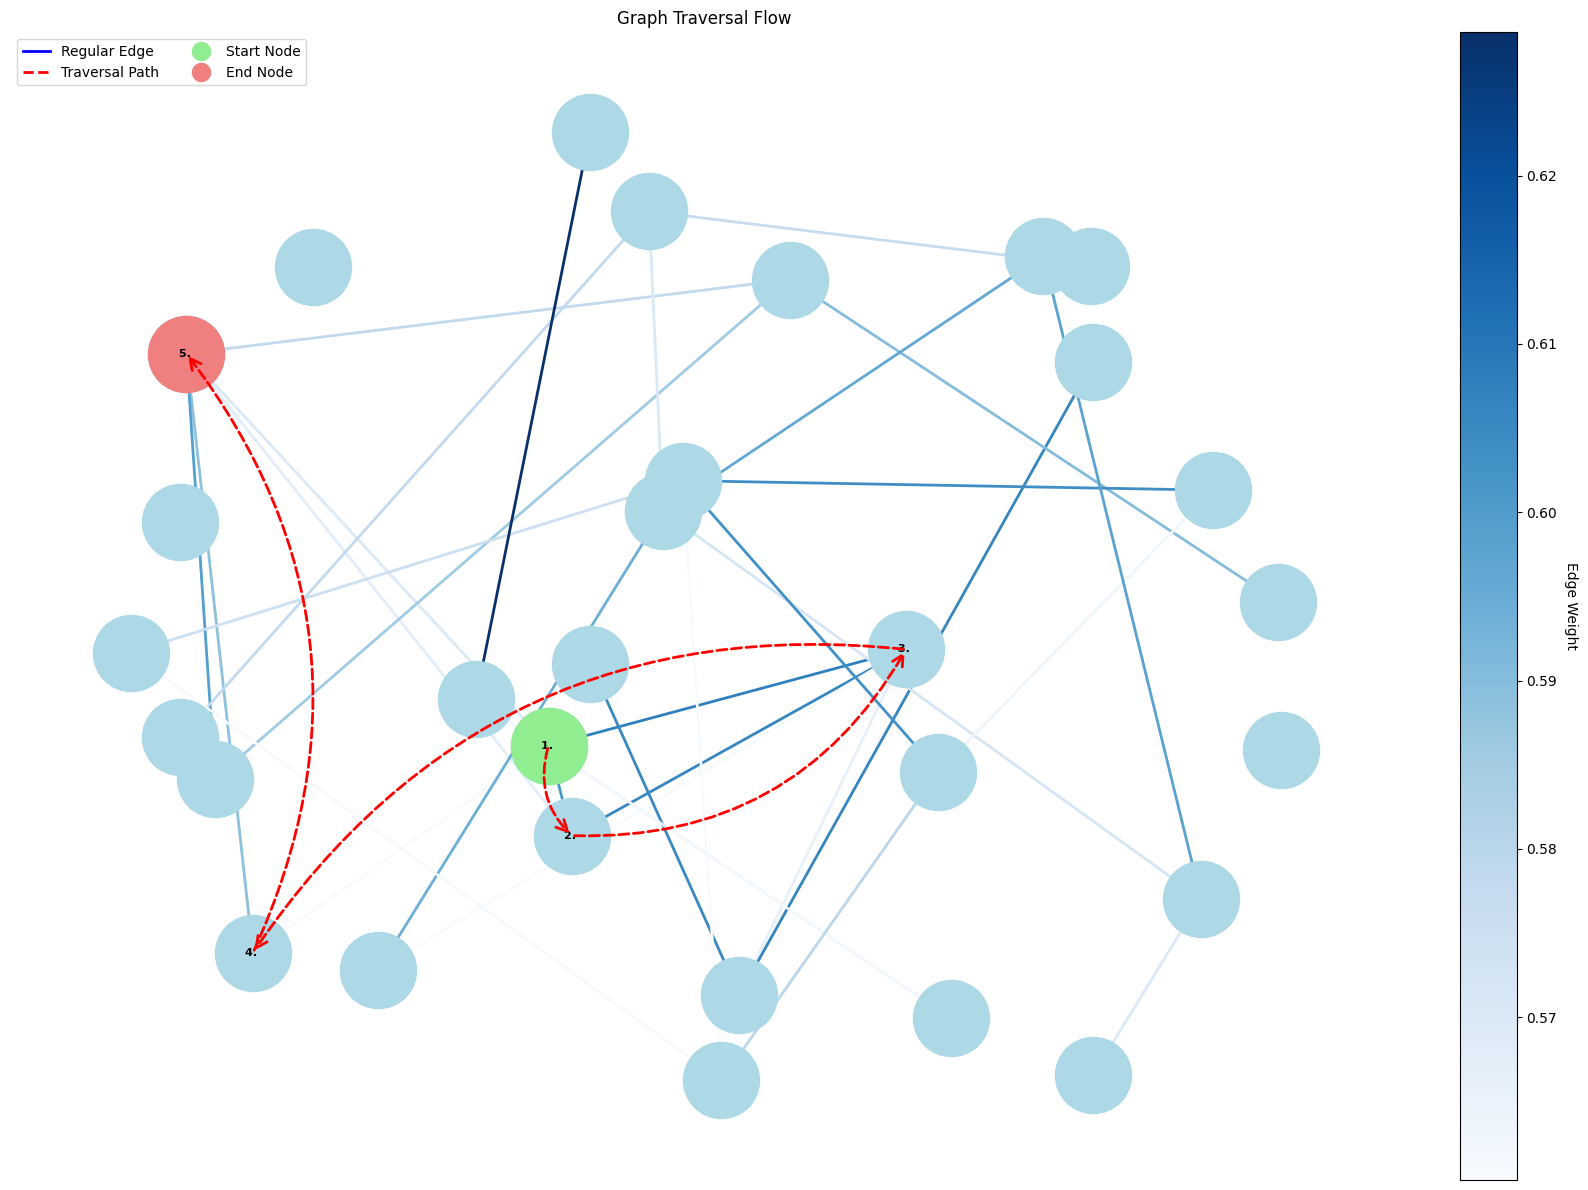


Filtered content of visited nodes in order of traversal:

Step 1 - Node 0:
Filtered Content: Understanding Climate Change 
Chapter 1: Introduction to Climate Change 
Climate change refers to significant, long-term changes in the global climate. The term 
"global climate" encompasses the plane...
--------------------------------------------------

Step 2 - Node 1:
Filtered Content: Most of these climate changes are attributed to very small variations in Earth's orbit that 
change the amount of solar energy our planet receives. During the Holocene epoch, which 
began at the end o...
--------------------------------------------------

Step 3 - Node 2:
Filtered Content: Chapter 2: Causes of Climate Change 
Greenhouse Gases 
The primary cause of recent climate change is the increase in greenhouse gases in the 
atmosphere. Greenhouse gases, such as carbon dioxide (CO2)...
--------------------------------------------------

Step 4 - Node 7:
Filtered Content: development of eco-friendly ferti

In [44]:
query = "what is the main cause of climate change?"
response = graph_rag.query(query)

# Graph-Based RAG System: KnowledgeGraph + QueryEngine

This notebook cell explains **how the system works**, step by step, from document ingestion to answering queries.

---

## 1️⃣ Overall Architecture

The system consists of the following components:

1. **DocumentProcessor**
   - Splits documents into smaller chunks.
   - Generates embeddings for semantic similarity searches.

2. **KnowledgeGraph**
   - Represents document chunks as nodes.
   - Each node stores:
     - Original content
     - Extracted concepts (named entities + general concepts)
   - Edges represent semantic similarity + concept overlap.
   - Edge weights combine similarity and shared concepts.

3. **QueryEngine**
   - Retrieves relevant nodes from the vector store.
   - Traverses the knowledge graph intelligently to expand context.
   - Checks if the accumulated context sufficiently answers the query.
   - Generates the final answer using a large language model (LLM) if needed.

4. **Visualizer**
   - Plots the traversal path.
   - Highlights start/end nodes, edges, and traversal flow.

5. **GraphRAG**
   - Integrates all components.
   - Provides a simple `query()` interface.

---

## 2️⃣ KnowledgeGraph Component

**Purpose:** Build a graph-based representation of your documents, capturing semantic relationships.

### **Workflow:**

1. **Add Nodes**
   - Each document chunk becomes a node.
   - Node stores:
     - `content` → actual text
     - `concepts` → key ideas and named entities

2. **Extract Concepts**
   - Uses **spaCy** for named entities (PERSON, ORG, GPE, WORK_OF_ART).
   - Uses **LLM** for general concepts.
   - Combines both into a single `concepts` list.
   - Concept caching avoids repeated extraction for the same content.

3. **Create Embeddings**
   - Each chunk is embedded using an embedding model (e.g., OllamaEmbeddings).
   - Embeddings allow **semantic similarity computation**.

4. **Compute Similarities**
   - Cosine similarity between embeddings.
   - Similarity matrix determines potential edges.

5. **Add Edges**
   - Connect nodes with similarity above a threshold (default 0.8).
   - Edge weight = `α * similarity + β * normalized shared concepts`.
   - Encourages connections between semantically and conceptually related nodes.

6. **Lemmatize Concepts**
   - Simplifies concepts to base forms for better comparison.
   - Example: "running" → "run", "dogs" → "dog".

**Result:**  
A graph where nodes are document chunks and edges represent **semantic + conceptual relationships**, ready for traversal by the QueryEngine.

---

## 3️⃣ QueryEngine Component

**Purpose:** Answer queries using the knowledge graph and LLM.

### **Workflow:**

1. **Retrieve Relevant Nodes**
   - Query is embedded.
   - Vector store finds top-k document chunks (nodes) most similar to the query.
   - Optional compression removes irrelevant content.

2. **Initialize Traversal**
   - Use a **priority queue** based on **strength of connection** (inverse edge weight).
   - Start with nodes retrieved from the vector store.

3. **Traverse Graph**
   - Explore nodes in order of strongest connection.
   - Accumulate content into `expanded_context`.
   - Track visited concepts to avoid redundant exploration.
   - For each node:
     - Add content to context.
     - Update traversal path.
     - Check **if current context provides a complete answer**.

4. **Answer Check**
   - A small LLM chain checks if accumulated context is sufficient.
   - Stops traversal early if answer is complete.

5. **Neighbor Exploration**
   - Expand only to neighbors that introduce new concepts.
   - Use edge weight to prioritize strong semantic/conceptual connections.

6. **Generate Final Answer**
   - If traversal didn’t find a complete answer, LLM generates the answer using all accumulated context.

7. **Output**
   - `final_answer` → Answer to the query.
   - `traversal_path` → Order of nodes visited in the graph.
   - `filtered_content` → Content of nodes used in traversal.

---

## 4️⃣ Graph Traversal Logic

- **Priority Queue** ensures the system explores **strongly connected nodes first**.
- **Concept tracking** prevents redundant exploration and focuses on new information.
- **Answer check at each step** prevents unnecessary traversal once the answer is found.
- **Final LLM call** ensures completeness if graph traversal is insufficient.


---

## 5️⃣ Integration in GraphRAG

- **GraphRAG** orchestrates all components:
  1. Process documents → build vector store and knowledge graph.
  2. Query → use QueryEngine to find answer.
  3. Visualize → show traversal path and filtered content.

**Key Benefits:**
- Combines **semantic search** and **graph-based reasoning**.
- Efficient exploration via **priority + concept tracking**.
- Ensures **high-quality, complete answers**.

---

**✅ Summary:**  
- **KnowledgeGraph** encodes documents and relationships.  
- **QueryEngine** intelligently explores the graph to answer queries efficiently.  
- Together, they enable **graph-based RAG** with LLM support for reasoning and answer generation.

                                               
